<a href="https://colab.research.google.com/github/MD2001/Pytorch_Bignnier/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

02. Neural Network classification with PyTorch
Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).
Book version of this notebook https://www.learnpytorch.io/02_pytorch_classification/

All other resources - https://github.com/mrdbourke/pytorch-deep-learning

Stuck? Ask a question https://github.com/mrdbourke/pytorch-deep-learning/
discussions

In [2]:
import sklearn

#Data

In [3]:
from sklearn.datasets import make_circles

n_samples = 2000

X,Y =make_circles(n_samples,
                  noise=0.03,
                  random_state=42)

print(f"first five element from X : \n{X[:5]}")
print(f"first five element from Y : \n{Y[:5]}")


first five element from X : 
[[ 0.47109875 -0.58158579]
 [-0.61696058  0.80818956]
 [-0.3999557   0.70796779]
 [ 0.82938523 -0.60057314]
 [-0.16419138  0.76128858]]
first five element from Y : 
[1 0 1 0 1]


In [4]:
# visualise data
import pandas as pd
circles = pd.DataFrame({
                          "X1" : X[:,0],
                          "X2" : X[:,1],
                          "labels"  : Y[:]
})
circles.head(10)

,X1,X2,labels
0,0.471099,-0.581586,1
1,-0.616961,0.808190,0
2,-0.399956,0.707968,1
3,0.829385,-0.600573,0
4,-0.164191,0.761289,1
5,-0.161906,0.778817,1
6,0.970100,-0.354272,0
7,-0.105737,-0.804784,1
8,0.908106,0.459450,0
9,-0.342749,0.730214,1


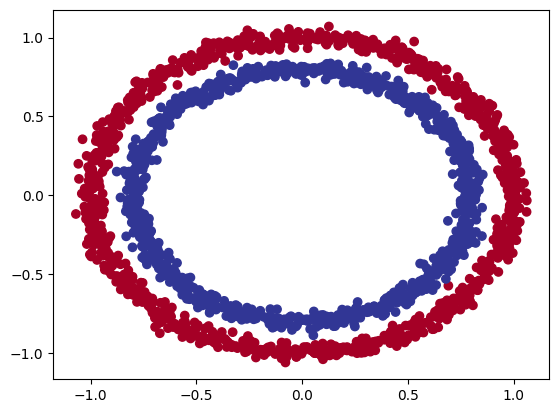

In [6]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=Y[:],
            cmap=plt.cm.RdYlBu)

after visualize data i assume it two circle and the input is coordinate to determine which do belonge to witch circle